In [47]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn import linear_model
#from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from dask import dataframe as ddf
from matplotlib import pyplot

In [23]:
data = ddf.read_csv("/Users/shoutianze/Desktop/F23/36490/36490-F23-Group1/data/usa.csv", dtype={'adjfct': 'float64',
                                                                                                'gvkey': 'float64',
                                                                                                'iid': 'object',
                                                                                                'naics': 'float64',
                                                                                                'sic': 'float64',
                                                                                                'tvol': 'float64',
                                                                                                'crsp_exchcd': 'float64',
                                                                                                'crsp_shrcd': 'float64',
                                                                                                'fx': 'float64',
                                                                                                'permco': 'float64',
                                                                                                'permno': 'float64',
                                                                                                'ret_lag_dif': 'float64'})
data = data.compute()

In [24]:
## DATA TRANSFORMATION

#define start date and end date of training set
train_start = 19900000
train_end = 20000000

#define start date and end date of test set
test_start = 20000000
test_end = 20220000

#exclude data that's not during the period
data = data[(data["date"] > train_start) & (data["date"] < test_end)]

#exclude observations with missing market equity in month t and missing return in month t+1
data = data.dropna(subset=['me', 'ret_exc_lead1m'])

#exclude nano caps
data = data.loc[data['size_grp'] != 'nano']

#delete observation with more than 5 out of the 21 characteristics missing
cols = ["be_me", "ret_12_1", "market_equity", "ret_1_0", "rvol_252d", "beta_252d", "qmj_safety", "rmax1_21d", "chcsho_12m",
        "ni_me", "eq_dur", "ret_60_12", "ope_be", "gp_at", "ebit_sale", "at_gr1", "sale_gr1", "at_be","cash_at", "age", "z_score"]

data["missing_num"] = data[cols].isna().sum(1)
data = data.loc[data['missing_num'] <= 5]

#impute the missing characteristics by replacing them with the cross-sectional median
for i in cols:
    data[i] = data[i].astype(float)
    data[i] = data[i].fillna(data.groupby('date')[i].transform('median'))

cols1 = ["permno","date","ret_exc_lead1m", "be_me", "ret_12_1", "market_equity", "ret_1_0", "rvol_252d", "beta_252d",
         "qmj_safety", "rmax1_21d", "chcsho_12m","ni_me", "eq_dur", "ret_60_12", "ope_be", "gp_at", "ebit_sale", "at_gr1", "sale_gr1",
         "at_be","cash_at", "age", "z_score"]

data1 = data[cols1]
data1 = data1.dropna()

#rank transformation
#each characteristics is transformed into the cross-sectional rank
for i in cols:
    data1[i] = data1.groupby("date")[i].rank(pct=True)

#use df, store data1
df = data1
df.sort_values(by=['date', 'permno'], inplace=True)

# lists of months
train_month_list = df.date.unique()

df_test = df[(df["date"] > test_start) & (df["date"] < test_end)]
obj_month_list = df_test.date.unique()

In [25]:
#optimization part
def regularizer(beta):
    return cp.norm1(beta)

def loss_fn(X, Y, beta, intercept):
    return (1.0 / X.shape[0]) *(cp.norm2(X @ beta + intercept - Y)**2)

#objective function 1 - L1 penalty on the coefficient
def objective_fn_initial(X, Y, beta, intercept, lambda1):
    return loss_fn(X, Y, beta, intercept) + lambda1 * cp.norm1(beta)

#coefficients, intercepts and objective values
beta_list = np.zeros((len(cols), 3))
intercept_list = np.zeros(3)
objective_list = np.zeros(3)

#set your own penalty parameters
lambda1_value = 0.0005

index = list(train_month_list).index(obj_month_list[0])
data_train = df[(df["date"] < train_month_list[index]) & (df["date"] >=train_month_list[index-5])]
X_train = data_train[cols].to_numpy()
Y_train = data_train["ret_exc_lead1m"].to_numpy()

#sklearn
model_lasso = linear_model.Lasso(alpha=lambda1_value/2)
model_lasso.fit(X_train, Y_train)
beta_list[:,0] = model_lasso.coef_
intercept_list[0] = model_lasso.intercept_
objective_list[0] = np.linalg.norm(model_lasso.coef_, ord=1)

#cvx with objective function 1
beta = cp.Variable(len(cols))
intercept = cp.Variable(1)
problem = cp.Problem(cp.Minimize(objective_fn_initial(X_train, Y_train, beta, intercept, lambda1_value)))
problem.solve(solver = cp.SCS)
#beta_list[:,2] = beta.value
#Choose your own threshold here. I chose 0.0001.
beta_list[:,1] = np.where(abs(beta.value) < 0.0001, 0, beta.value)
intercept_list[1] = intercept.value
objective_list[1] = problem.value
objective_list[1] = np.linalg.norm(beta.value, ord=1)


#The estimates in each column should be very close. Because there are the same model when lambda2_value = 0
#Feel free to try different penalty parameters and write your own optimization problems.

/var/folders/29/l7nrj2kj79s5n10vdwh2ywnc0000gn/T/ipykernel_86387/4015067490.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  intercept_list[1] = intercept.value


Below we try Grid CV with cvspy

/var/folders/29/l7nrj2kj79s5n10vdwh2ywnc0000gn/T/ipykernel_86387/1276853670.py:26: RuntimeWarning: divide by zero encountered in log
  log_lambdas = [np.log(lam) for lam in lambda_list]


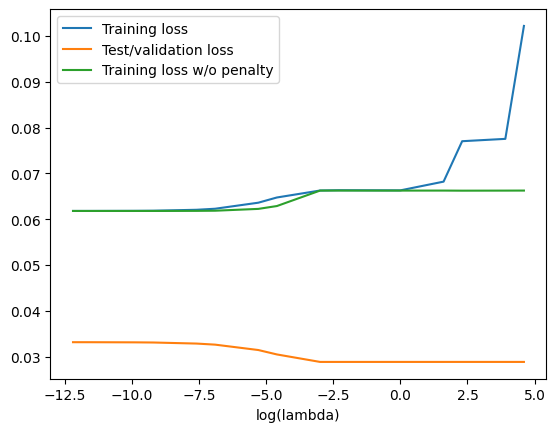

In [52]:
def test_loss_fn(X, Y, beta, intercept):
    return (1.0 / X.shape[0]) *(np.linalg.norm(X @ beta + intercept - Y)**2)

X_test = df_test[cols].to_numpy()
Y_test = df_test["ret_exc_lead1m"].to_numpy()

lambda_list = [0, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
train_objective_list = []
train_objective_list_wo_penalty = []
beta_list = []
intercept_list = []
test_objective_list = []

for lambda_value in lambda_list:
    beta = cp.Variable(len(cols))
    intercept = cp.Variable(1)
    problem = cp.Problem(cp.Minimize(objective_fn_initial(X_train, Y_train, beta, intercept, lambda_value)))
    problem.solve(solver = cp.SCS)

    beta_list.append(np.where(abs(beta.value) < 0.0001, 0, beta.value))
    intercept_list.append(intercept.value)
    train_objective_list.append(problem.value)
    train_objective_list_wo_penalty.append(test_loss_fn(X_train, Y_train, beta.value, intercept.value))
    test_objective_list.append(test_loss_fn(X_test, Y_test, beta.value, intercept.value))

log_lambdas = [np.log(lam) for lam in lambda_list]
pyplot.plot(log_lambdas, train_objective_list, label="Training loss")
pyplot.plot(log_lambdas, test_objective_list, label="Test/validation loss")
pyplot.plot(log_lambdas, train_objective_list_wo_penalty, label="Training loss w/o penalty")
pyplot.xlabel("log(lambda)")
pyplot.legend()
pyplot.show()


In [44]:


test_loss_fn(X_test, Y_test, beta.value, intercept.value)

0.028888676750403987